# Implémentation d'un RNN pour générer des accords appris sur le realbook.
## Implémentation en pytorch à partir de l'implémentation en Keras proposée par keunwoochoi
Github du projet de référence https://github.com/keunwoochoi/lstm_real_book

# Importation des librairies utiles :

In [1]:
import numpy as np
import random
import sys
import torch
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Définition d'une petite fonction utile :

In [2]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Création de l'objet RNN :

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Importation de la base de données :

In [4]:
path = 'chord_sentences.txt' # the txt data source
text = open(path).read()
print('corpus length:', len(text))

chord_seq = text.split(' ')
chars = set(chord_seq)
text = chord_seq


# Création de dictionnaires contenants les noms
# des accords contenus dans le realbook

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
num_chars = len(char_indices)
print('total chars:', num_chars)

corpus length: 3531261
total chars: 1260


# Coup d'oeil sur la structure de la base de données : 
Les morceaux sont repérés par des "_START_" et des "_END_"

Voyez plutôt :

In [5]:
#Affichage du début de la base de données
print(text[0:200])

['_START_', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'G:9', 'G:9', 'G:9', 'G:9', 'G:9', 'G:9', 'G:9', 'G:9', 'C:9', 'C:9', 'C:9', 'C:9', 'C:7', 'C:7', 'C:7', 'C:7', 'F:maj', 'F:maj', 'F:maj', 'F:maj', 'F:min7', 'F:min7', 'F:min7', 'F:min7', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'G:min7', 'G:min7', 'G:min7', 'G:min7', 'A:7', 'A:7', 'A:7', 'A:7', 'D:9', 'D:9', 'D:9', 'D:9', 'G:9', 'G:9', 'G:9', 'G:9', 'E:min7', 'E:min7', 'G:7', 'G:7', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'A:min7', 'A:min7', 'A:min7', 'A:min7', 'A:min7', 'A:min7', 'A:min7', 'A:min7', 'E:min7', 'E:min7', 'E:min7', 'E:min7', 'E:min7', 'E:min7', 'E:min7', 'E:min7', 'F:maj7', 'F:maj7', 'F:maj7', 'F:maj7', 'F:7', 'F:7', 'F:7', 'F:7', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'C:7', 'C:7', 'F:maj', 'F:maj', 'F:maj', 'F:maj', 'F:min7', 'F:min7', 'F:min7', 'F:min7', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'A:7', 'A:7', 'A:7', 'A:7', 'D:7', 'D:7', 'D:7', 'D:7'

# Pour bien comprendre :

In [6]:
print(char_indices["C:maj"])
print(indices_char[669])

# Ici les indications START et END sont considérés comme des accords
# Nous devrions peut être changer cela

print(char_indices["_START_"])
print(indices_char[1195])
print(char_indices["_END_"])
print(indices_char[825])

1008
A:min/6
599
C#:7(b5,*5,b9)
1077
G:maj(2,*3)/5


# Déoupe de la bases de données :
On crée ici une liste qui contient des exemples de suite d'accords dont on va se servir pour créer nos vecteurs qui serviront à feed le RNN. 
Pourquoi ils sont découpés comme ça et pas par morceau ? Je ne sais pas, ça me parait bizare, peut être qu'il faudrait qu'on découpe par morceaux plutôt que de couper en 20.

In [7]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 20
step = 3
sentences = []
for i in range(0, len(text) - maxlen, step):
	sentences.append(text[i: i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 181761


# Transformation des exemples en vecteurs pour les utiliser en entrées et sorties du RNN.

In [8]:
def vectorize(sentences,maxlen,num_chars,char_indices):
    #limiting the dataset size to do fast exemples 
    max_dataset_lenght = 10000
    print('Vectorization...')
    len_dataset = min(max_dataset_lenght, len(sentences))
    X = torch.zeros(len_dataset, maxlen, 1, num_chars)
    Y = torch.zeros((len_dataset, maxlen, 1),dtype = torch.long)
    for i, sentence in enumerate(sentences[0:len_dataset]):
        for t, char in enumerate(sentence[0:len_dataset]):
            X[i, t, 0, char_indices[char]] = 1
            Y[i, t, 0] = char_indices[char]
    print("done")
    print("X.size() : ")
    print(X.size())
    print("Y.size() : ")
    print(Y.size())
    return X, Y


# text to vectors
X, Y = vectorize(sentences,maxlen,num_chars,char_indices)

Vectorization...
done
X.size() : 
torch.Size([10000, 20, 1, 1260])
Y.size() : 
torch.Size([10000, 20, 1])


# Création de la fonction train du réseau :

In [11]:
def train(X_in,Y_out):
    #target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(len(X_in) - 1):
        output, hidden = rnn(X_in[i], hidden)
        l = criterion(output, Y_out[i+1])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / X.size(0)

# Création du réseau et définition de la boucle d'entraînement :

In [12]:
rnn = RNN(num_chars, 128, num_chars)

n_iters = 5000
print_every = 50
plot_every = 10
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

criterion = nn.NLLLoss()

learning_rate = 0.0005

print("Début de l'entraînement")
for iter in range(1, n_iters + 1):
    index_in_data = iter % len(X)
    output, loss = train(X[index_in_data], Y[index_in_data])
    total_loss += loss
    

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

Début de l'entraînement
0m 14s (50 1%) 0.0134


KeyboardInterrupt: 

# Plot de la fonction Loss :

Bon ça converge pas de ouf, ni très vite d'ailleurs.


Ca manque sûrement d'exemple dans la base de données. (on a tronqué à pas beaucoup comparé à la taille du fichier)


Et les données sont présentées de manière pourrie, on devrait peut être faire des apprentissages par morceaux et pas par séquences de 20 "accords".

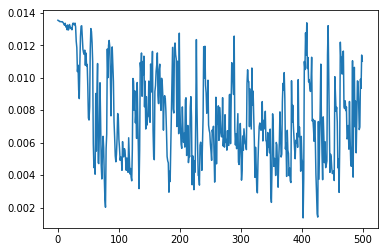

In [11]:
plt.figure()
plt.plot(all_losses)
plt.show()

# Génération d'une séquence d'accords à partir d'un blues en Do majeur :

## Génération de la séquence de blues :

In [12]:
test_sequence = ["_START_","C:maj","F:maj","C:maj","C:maj","F:maj","F:maj","C:maj","C:maj","G:maj","F:maj"]

test_sequence_tensor = torch.zeros(len(test_sequence), 1, num_chars)
for t in range(len(test_sequence)):
    test_sequence_tensor[t, 0, char_indices[test_sequence[t]]] = 1


## Utilisation de la séquence pour les premiers accords puis génération par le réseau d'une éventuelle suite :

Visiblement l'algo aime bien les Do7...

In [13]:
hidden = rnn.initHidden()
generation_lenght = 100

generated_sequence = [0 for i in range(generation_lenght)]

for t in range(generation_lenght):
    if t < len(test_sequence):
        output, hidden = rnn(test_sequence_tensor[t], hidden)
        generated_sequence[t] = test_sequence[t]
    else : 
        last_chord_output = torch.zeros(1, num_chars)
        last_chord_output[0, torch.argmax(output).item()]
        output, hidden = rnn(last_chord_output, hidden)
        generated_sequence[t] = indices_char[torch.argmax(output).item()]

        
print(generated_sequence)

['_START_', 'C:maj', 'F:maj', 'C:maj', 'C:maj', 'F:maj', 'F:maj', 'C:maj', 'C:maj', 'G:maj', 'F:maj', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:m

# Test avec une séquence blues plus lente et détaillée

ça a pas l'air bien mieux 

In [14]:
test_sequence = ["_START_","C:maj","C:maj","F:maj","F:maj","C:maj","C:maj","C:maj","C:maj",
                 "F:maj","F:maj","F:maj","F:maj","C:maj","C:maj","C:maj","C:maj",
                 "G:7","G:7","F:maj","F:maj","C:maj","C:maj","F:maj","G:7"]

test_sequence_tensor = torch.zeros(len(test_sequence), 1, num_chars)
for t in range(len(test_sequence)):
    test_sequence_tensor[t, 0, char_indices[test_sequence[t]]] = 1


In [15]:
hidden = rnn.initHidden()
generation_lenght = 100

generated_sequence = [0 for i in range(generation_lenght)]

for t in range(generation_lenght):
    if t < len(test_sequence):
        output, hidden = rnn(test_sequence_tensor[t], hidden)
        generated_sequence[t] = test_sequence[t]
    else : 
        last_chord_output = torch.zeros(1, num_chars)
        last_chord_output[0, torch.argmax(output).item()]
        output, hidden = rnn(last_chord_output, hidden)
        generated_sequence[t] = indices_char[torch.argmax(output).item()]

        
print(generated_sequence)

['_START_', 'C:maj', 'C:maj', 'F:maj', 'F:maj', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'F:maj', 'F:maj', 'F:maj', 'F:maj', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'G:7', 'G:7', 'F:maj', 'F:maj', 'C:maj', 'C:maj', 'F:maj', 'G:7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'C:min7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'C:min7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj7', 'A#:maj